# Investigating features

In [1]:
import json
import pickle
import itertools

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import torch

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.patches import Patch
from matplotlib.colors import Normalize
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from fault_management_uds.synthetic.synthetic_generator import find_unterrupted_sequences

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from fault_management_uds.plots import pca_plot


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauge_color, condition_to_meta


from fault_management_uds.data.load import import_metadata


2025-01-04 10:06:09.640 | INFO     | fault_management_uds.config:<module>:15 - PROJ_ROOT path is: /work3/s194262/GitHub/fault_management_uds
2025-01-04 10:06:10.603766: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-04 10:06:10.694294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735981570.739355  538383 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735981570.752569  538383 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
20

In [2]:
hue_map = {
    'Spike': 'OrangeRed',
    'Noise': 'DarkGray',
    'Frozen': 'SteelBlue',
    'Offset': 'Gold',
    'Drift': 'LightSeaGreen',
    'Original': 'blanchedalmond', 
}
hue_order = list(hue_map.keys())[::-1]
# load
indicator_2_data_label = json.load(open(REFERENCE_DIR / 'indicator_2_data_label.json', 'r'))

## Load

In [3]:
model_save_path = 'transformer/7_anomalous/testing_2dim'
data_type = 'test'
data_group = 'anomalous'

In [4]:
# load data
anomalous_path = MODELS_DIR / model_save_path / '1_split' / 'anomalous'

# pickle
outputs = pickle.load(open(anomalous_path / 'outputs.pkl', 'rb'))
print(f"Outputs: {outputs.shape}")
# json
column_2_idx = json.load(open(anomalous_path / 'column_2_idx.json', 'r'))
column_2_idx = {(k[0].upper() + k[1:]).replace('_', ' '): v 
                for k, v in column_2_idx.items()}

print(f"Column 2 idx: {list(column_2_idx.keys())}")

Outputs: (867247, 74)
Column 2 idx: ['Starttime', 'Valid index', 'Data label', 'Target', 'Residual', 'Prediction', 'Final hidden', 'IG', 'PIG']


In [5]:
# The hidden state should be shifted 1 back
remove_last = 0
if 'Final hidden' in column_2_idx:
    # Shift it by 1 and remove the last one
    final_hidden_idx = column_2_idx['Final hidden']
    outputs[:, final_hidden_idx] = np.roll(outputs[:, final_hidden_idx], -1) # shift by 1 back
    remove_last = 1

if 'IG' in column_2_idx:
    # Shift it by 1 and remove the last one
    integrated_gradients_idx = column_2_idx['IG']
    outputs[:, integrated_gradients_idx] = np.roll(outputs[:, integrated_gradients_idx], -1) # shift by 1 back
    remove_last = 1

    
# remove the last one
outputs = outputs[:-remove_last]
print(f"Outputs: {outputs.shape}")

Outputs: (867246, 74)


In [6]:
# Add the 10 steps ahead prediction

# Load
save_path = MODELS_DIR / model_save_path / "1_split/evaluation" / data_type / "output.pkl"
n_steps_preds = pickle.load(open(save_path, 'rb'))
print(n_steps_preds.keys()) 
steps_ahead = n_steps_preds['predictions'].shape[2]
print(steps_ahead)
# extract the last step predictions
last_step_preds = n_steps_preds['predictions'][:, :, -1]
# Shift by steps_ahead minutes
last_step_ts = pd.to_datetime(n_steps_preds['timestamps']) + pd.Timedelta(minutes=steps_ahead - 1)

# Time stamps in the outputs data
starttimes = pd.to_datetime(outputs[:, column_2_idx['Starttime']].flatten())


# Filter valid timestamps
mask = last_step_ts.isin(starttimes)
valid_last_step_ts = last_step_ts[mask]
valid_step_preds = last_step_preds[mask]
del mask

# Locate the index in starttimes, where it is also in valid_last_step_ts
indices = np.searchsorted(starttimes, valid_last_step_ts)

# Output results
print(f"Found matches for {len(indices)} out of {len(last_step_ts)}")
# Filter outputs and add new column
column_2_idx['Residual@10'] = [outputs.shape[1]]  # Update column mapping
# calculate the residuals
residuals = outputs[indices, column_2_idx['Target']] - valid_step_preds.flatten()
outputs = np.hstack([outputs[indices], residuals.reshape(-1, 1)])
print(f"Outputs: {outputs.shape}")

del valid_last_step_ts, valid_step_preds, indices, last_step_ts, last_step_preds, starttimes, residuals


dict_keys(['predictions', 'targets', 'endogenous_vars', 'timestamps'])
10
Found matches for 867030 out of 867031
Outputs: (867030, 75)


In [7]:
feature_columns = ['Target', 'Residual', 'Residual@10', 'Final hidden', 'IG', 'PIG',]
feature_columns = [x for x in feature_columns if x in column_2_idx]
feature_2_idx = {k: column_2_idx[k] for k in feature_columns}
all_feature_indices = []
feature_idx_names = []
for k in feature_columns:
    all_feature_indices.extend(feature_2_idx[k])

    feature_idx_names.extend([k + '_' + str(len(feature_2_idx[k])-i) if len(feature_2_idx[k]) > 1 else k for i in range(len(feature_2_idx[k]))])

# get the coloring variable
data_label = outputs[:, column_2_idx['Data label']].flatten()
# convert to label using indicator_2_data_label
data_label = [indicator_2_data_label[str(int(x))] for x in data_label]

In [8]:
# # normalize each feature
# for k in feature_columns:
#     feature_indices = feature_2_idx[k]
#     outputs[:, feature_indices] = normalize(outputs[:, feature_indices], axis=0)

In [9]:
# arr = np.array([[[1.1,2.1],[1.2,2.2], [1.3,2.3]]])
# print(arr.shape), print(arr)

# print(arr[:, -2:, :].reshape(1, -1))

## PCA

In [10]:
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(outputs[:, all_feature_indices])

# Apply PCA
max_components = 20
n_components = min(max_components, len(all_feature_indices))
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_scaled)

# DataFrame with the PCA components
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
# add the coloring column
pca_df['Data label'] = data_label 
# Get the explained variance
explained_variance = pca.explained_variance_ratio_

# Get the loadings (components)
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to match feature-column structure
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],  
    index=feature_idx_names
)
# free up memory
del pca_result

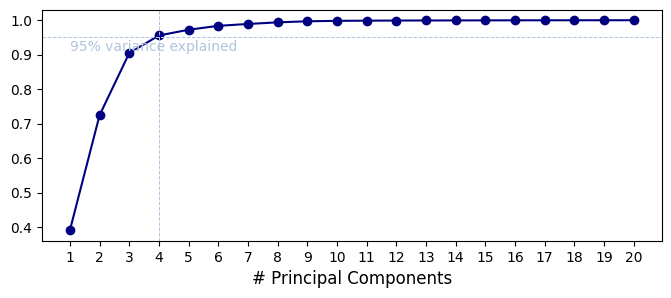

In [11]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 3))
plt.plot(np.arange(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', color='navy')
plt.axhline(y=0.95, color='lightsteelblue', linestyle='--', linewidth=0.7)
plt.text(0.99, 0.91, '95% variance explained', color = 'lightsteelblue', fontsize=10)
idx_95 = np.argmax(np.cumsum(explained_variance) > 0.95)
plt.axvline(x=idx_95 + 1, color='lightsteelblue', linestyle='--', linewidth=0.7)
plt.xlabel('# Principal Components', fontsize=12)
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.show()

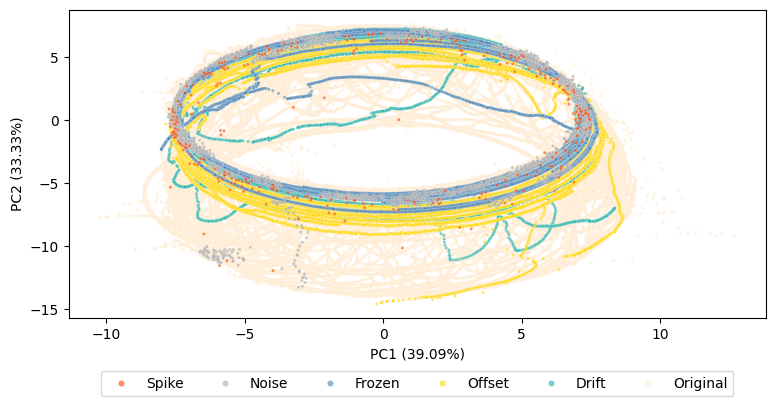

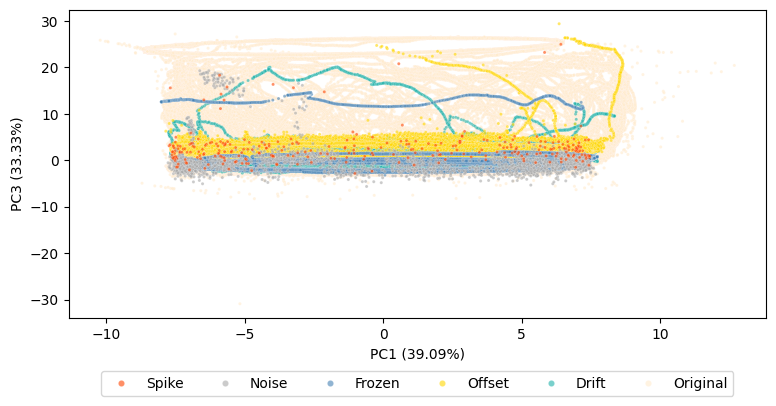

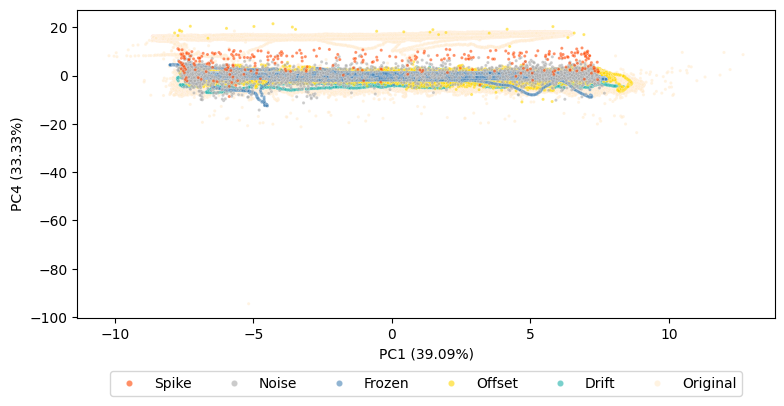

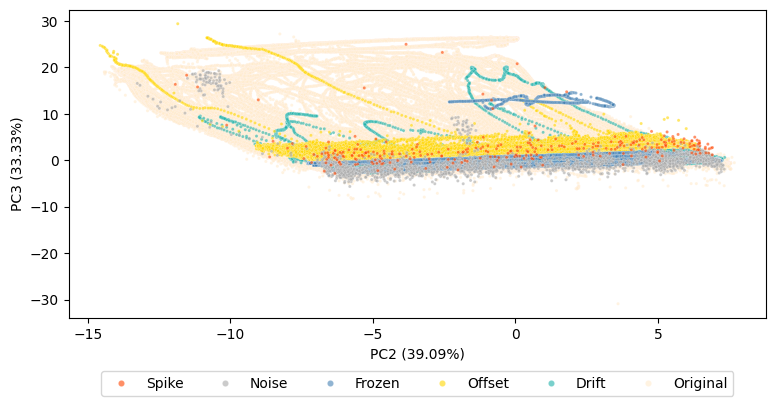

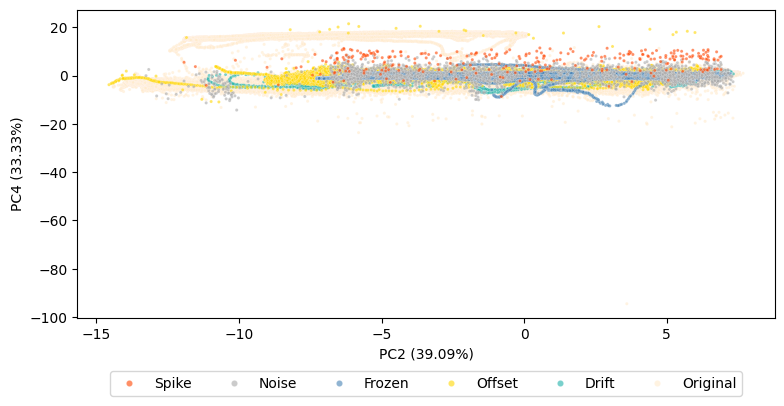

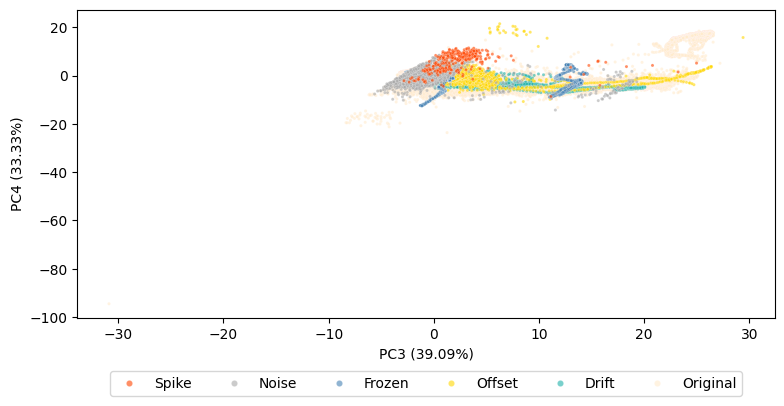

In [12]:
plot_pcs = list(pca_df.columns[list(range(max_components))])
plot_pcs = ['PC1', 'PC2', 'PC3', 'PC4']
pcs_combs = list(itertools.combinations(plot_pcs, 2))

for x, y in pcs_combs:
    pca_plot(pca_df, x, y, explained_variance, 'Data label', hue_map,
             plot_loadings=False, loadings=None)

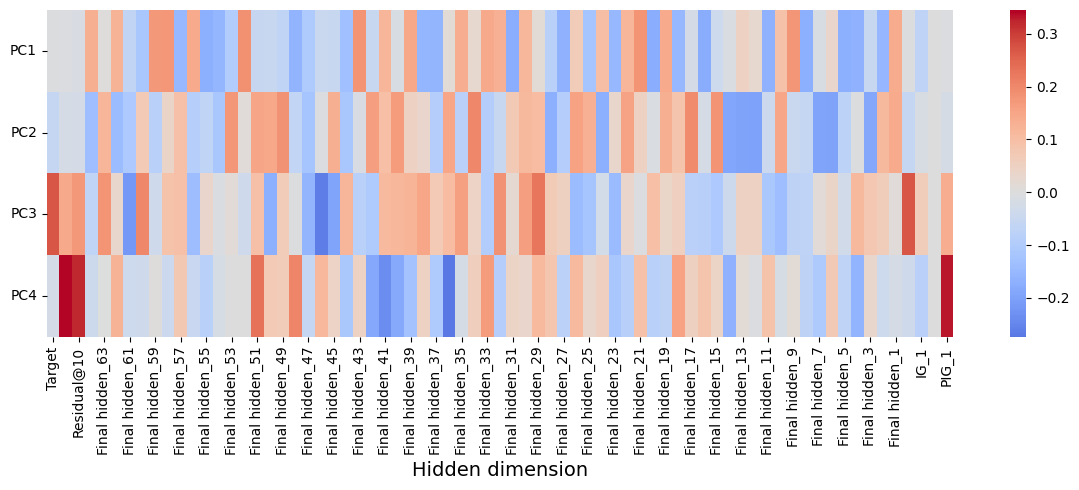

In [13]:
# visualize like the confsion matrix
n_components = idx_95+1 # seem to explain most of the variance
plt.figure(figsize=(12, 5))
sns.heatmap(loadings.iloc[:, :n_components].T, annot=False, cmap='coolwarm', center=0, fmt=".2f", cbar=True)
plt.xlabel('Hidden dimension', fontsize=14)
# rotate the y labels
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
# free up memory
del pca_df, loadings, df_scaled

## t-SNE

In [15]:
# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42)  # 2D visualization
# X_tsne = tsne.fit_transform(df_scaled)

# # Store t-SNE results
# tsne_df = pd.DataFrame(X_tsne, columns=['t-SNE1', 't-SNE2'])
# tsne_df['Data label'] = data_label
# del X_tsne

In [16]:
# # Visualize the results
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x='t-SNE1', y='t-SNE2', 
#                 data=tsne_df.sort_values('Data label', key=np.vectorize(hue_order.index)),
#                 hue='Data label', 
#                 hue_order=list(hue_map.keys()),
#                 palette=hue_map, s=6, alpha=0.7)
# plt.show()

In [17]:
# # free up memory
# del df_scaled#, tsne_df

## Detect anomalies

In [18]:
# Function to select and apply the anomaly detection model
def detect_anomalies(model_name, data, contamination='auto', n_neighbors=20, random_state=42):
    if model_name == 'IsolationForest':
        model = IsolationForest(
            contamination=contamination, 
            random_state=random_state
        )
        model.fit(data)
        predictions = model.predict(data)
        decision_function = model.decision_function(data)
        predictions = np.array([1 if x == -1 else 0 for x in predictions])
        return predictions, -decision_function

    elif model_name == 'OneClassSVM':
        model = OneClassSVM(
            #nu=contamination,  # Proportion of outliers
            kernel="rbf",  # Radial basis function kernel
            gamma="scale",  # Kernel coefficient
        )
        model.fit(data)
        predictions = model.predict(data)
        predictions = np.array([1 if x == -1 else 0 for x in predictions])
        return predictions, None  # One-Class SVM doesn't have a decision function like Isolation Forest

    elif model_name == 'LOF':
        model = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination, 
            novelty=False
        )
        lof_scores = model.fit_predict(data)
        predictions = np.array([1 if x == -1 else 0 for x in lof_scores])
        negative_outlier_factor = -model.negative_outlier_factor_
        return predictions, negative_outlier_factor

    else:
        raise ValueError(f"Model {model_name} is not recognized. Choose 'IsolationForest', 'OneClassSVM', or 'LOF'.")


In [19]:
results = {
    'Data label': data_label,
    'Actual': (outputs[:, column_2_idx['Data label']].flatten()!=0).astype(int),
}

# NOTE: IsolationForest is the only applicable model
model_name = 'IsolationForest' # ['IsolationForest', 'OneClassSVM', 'LOF']

evaluate_keys = ['Combined'] + feature_columns
evaluate_2_idx = feature_2_idx
evaluate_2_idx['Combined'] = all_feature_indices

# Now generate results for each feature column
for feature in evaluate_keys:
    print(f'Feature: {feature}')
    feature_indices = evaluate_2_idx[feature]
    predicted_anomalies, decision_function = detect_anomalies(model_name, outputs[:, feature_indices])
    results[feature] = {
        'Predicted': predicted_anomalies,
        'Decision Function': decision_function,
    }


Feature: Combined
Feature: Target
Feature: Residual
Feature: Residual@10
Feature: Final hidden
Feature: IG
Feature: PIG


## Performance comparison

#### Confusion Matrix & ROC

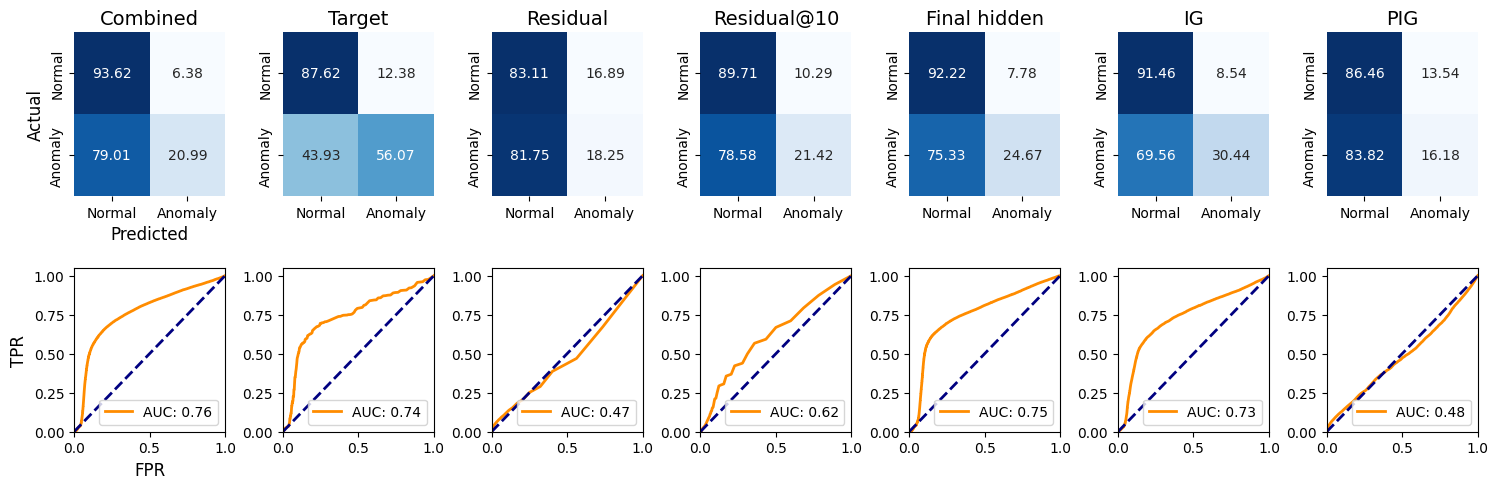

In [20]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, len(evaluate_keys), figsize=(15, 5))

for i, key in enumerate(evaluate_keys):
    # Confusion matrix
    conf_matrix = confusion_matrix(results['Actual'], results[key]['Predicted'])
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues', cbar=False, ax=axes[0, i])
    axes[0, i].set_title(key, fontsize=14)
    if i == 0:
        axes[0, i].set_ylabel('Actual', fontsize=12)
        axes[0, i].set_xlabel('Predicted', fontsize=12)
    # set y and x ticks
    axes[0, i].set_xticklabels(['Normal', 'Anomaly'], fontsize=10)
    axes[0, i].set_yticklabels(['Normal', 'Anomaly'], fontsize=10)

    # ROC curve
    fpr, tpr, _ = roc_curve(results['Actual'], results[key]['Decision Function'])
    roc_auc = auc(fpr, tpr)
    axes[1, i].plot(fpr, tpr, color='darkorange', lw=2, label='AUC: %0.2f' % roc_auc)
    axes[1, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    if i == 0:
        axes[1, i].set_ylabel('TPR', fontsize=12)
        axes[1, i].set_xlabel('FPR', fontsize=12)

    axes[1, i].legend(loc='lower right')
    axes[1, i].set_title(' ', fontsize=1)

plt.tight_layout()
plt.show()

Anomaly: Spike


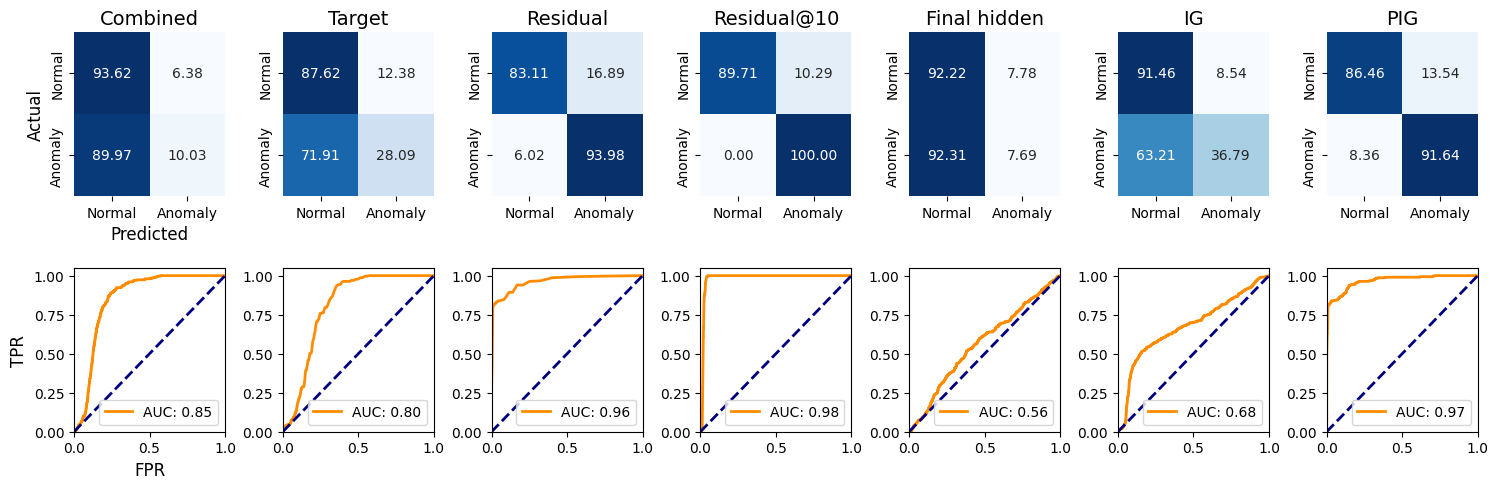



Anomaly: Noise


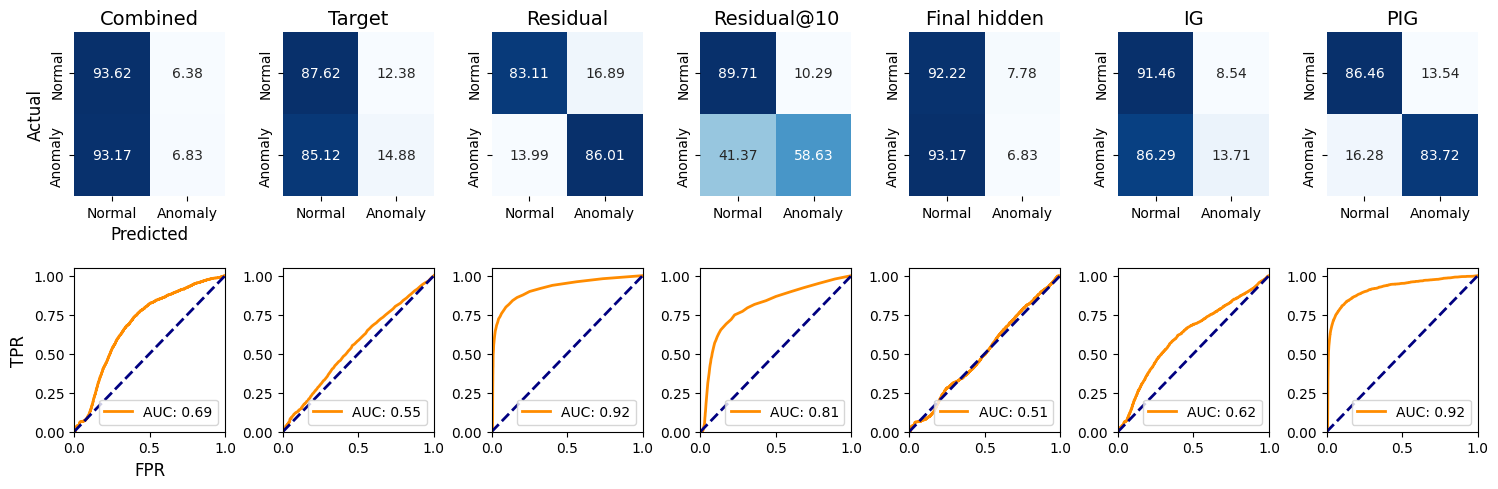



Anomaly: Frozen


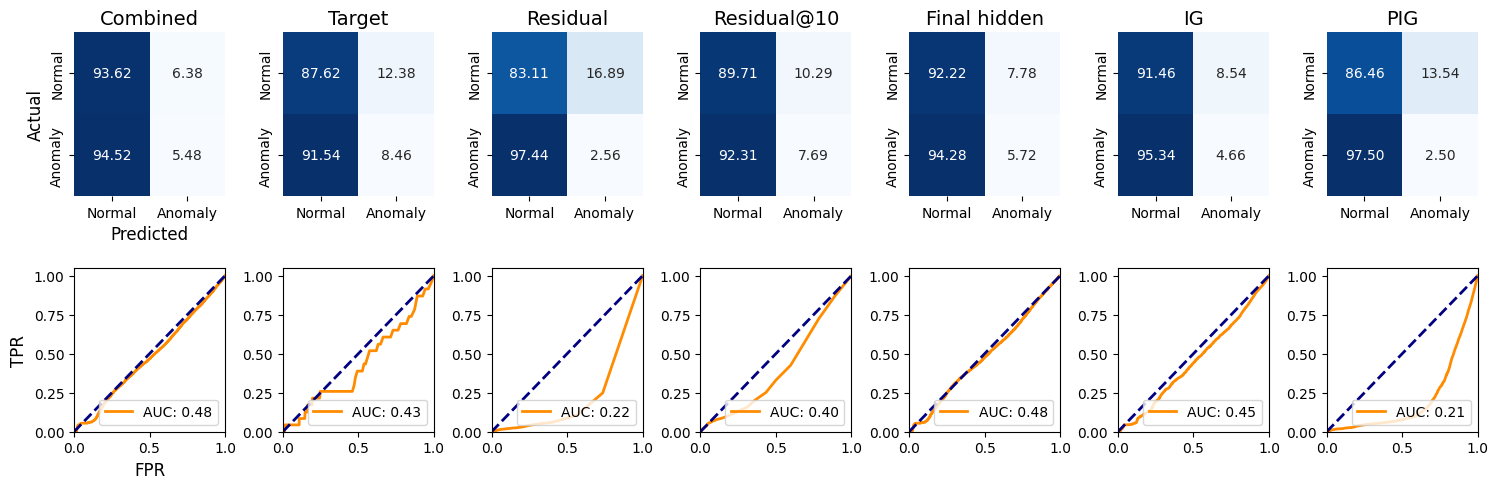



Anomaly: Offset


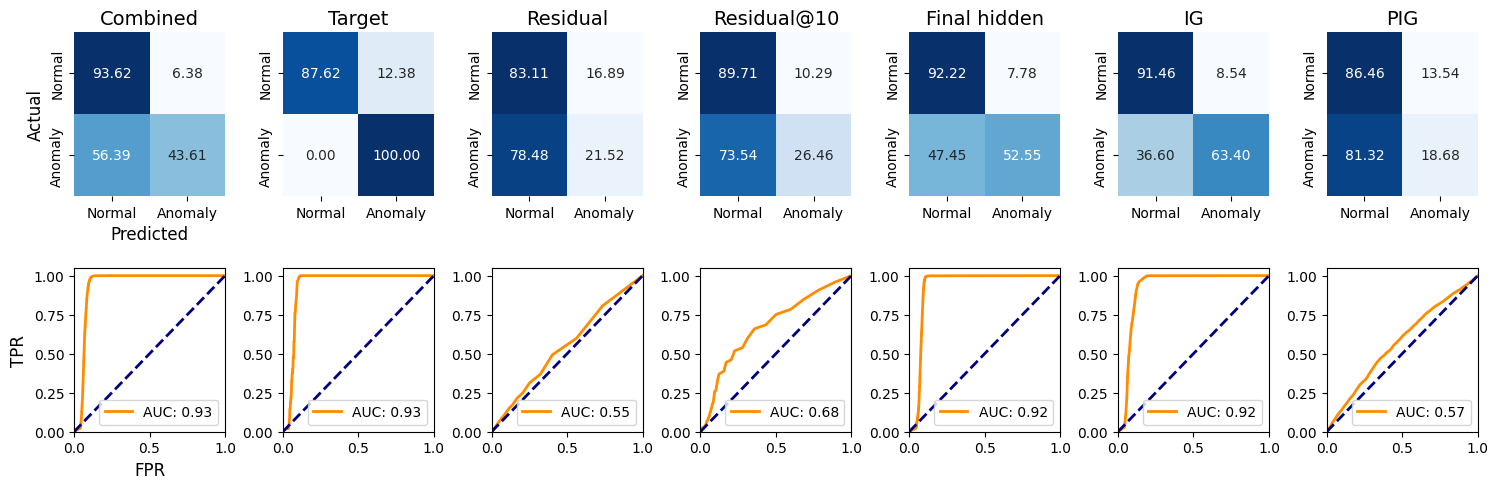



Anomaly: Drift


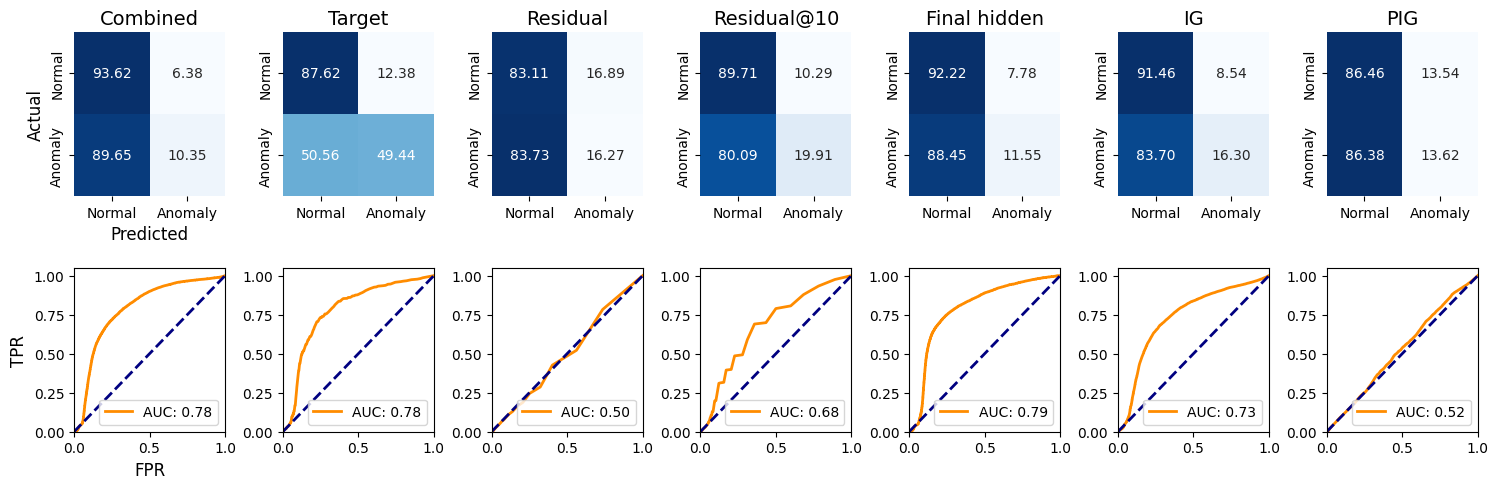

In [21]:

# For each anomaly
for label in hue_order[::-1]:
    if label == 'Original':
        continue

    print(f'Anomaly: {label}')
    mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')


    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(2, len(evaluate_keys), figsize=(15, 5))

    for i, key in enumerate(evaluate_keys):
        # Confusion matrix
        conf_matrix = confusion_matrix(results['Actual'][mask], results[key]['Predicted'][mask])
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
        sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues', cbar=False, ax=axes[0, i])
        axes[0, i].set_title(key, fontsize=14)
        if i == 0:
            axes[0, i].set_ylabel('Actual', fontsize=12)
            axes[0, i].set_xlabel('Predicted', fontsize=12)
        # set y and x ticks
        axes[0, i].set_xticklabels(['Normal', 'Anomaly'], fontsize=10)
        axes[0, i].set_yticklabels(['Normal', 'Anomaly'], fontsize=10)

        # ROC curve
        fpr, tpr, _ = roc_curve(results['Actual'][mask], results[key]['Decision Function'][mask])
        roc_auc = auc(fpr, tpr)
        axes[1, i].plot(fpr, tpr, color='darkorange', lw=2, label='AUC: %0.2f' % roc_auc)
        axes[1, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        if i == 0:
            axes[1, i].set_ylabel('TPR', fontsize=12)
            axes[1, i].set_xlabel('FPR', fontsize=12)

        axes[1, i].legend(loc='lower right')
        axes[1, i].set_title(' ', fontsize=1)

    plt.tight_layout()
    plt.show()
    print('\n')

## Metrics

In [22]:

def annotate_heatmap(data, data_fmt, ax, cmap='Blues', high_best=True):
    norm = Normalize(vmin=data.min(), vmax=data.max())
    cmap = plt.get_cmap(cmap)
    
    for i in range(data.shape[0]):  # Iterate over rows
        for j in range(data.shape[1]):  # Iterate over columns
            value = data[i, j]
            is_max = value == data[i].max() if high_best else value == data[i].min()
            text_kwargs = {"weight": "bold"} if is_max else {}
            
            # Get the background color for the cell
            bg_color = cmap(norm(value))
            
            # Determine text color (white or black) based on brightness
            brightness = 0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2]
            text_color = "white" if brightness < 0.80 else "black"
            
            # Add text annotation
            str_value = data_fmt[i, j]
            ax.text(j + 0.5, i + 0.5, str_value, ha="center", va="center", color=text_color, **text_kwargs)


In [23]:
# old plot
# precision_scores = {key: precision_score(results['Actual'], results[key]['Predicted'])*100 for key in evaluate_keys}

# # barplot
# plt.figure(figsize=(6, 3))
# plt.bar(precision_scores.keys(), precision_scores.values(), color='steelblue', alpha=0.7)
# # add the values on top
# for i, v in enumerate(precision_scores.values()):
#     plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontsize=12)
# # remove upper and right spines
# plt.gca().spines['top'].set_visible(False); plt.gca().spines['right'].set_visible(False)
# plt.tight_layout()
# plt.show()

#### Precision

In [24]:
# calculate precision score for each Data label
precision_scores = {}
for key in evaluate_keys:
    precision_scores[key] = {'Overall': precision_score(results['Actual'], results[key]['Predicted'])*100}
    for label in hue_order:
        if label == 'Original':
            continue
        mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')
        precision_scores[key][label] = precision_score(
            results['Actual'][mask], results[key]['Predicted'][mask]
        ) * 100

# Create a DataFrame with the precision scores
precision_df = pd.DataFrame(precision_scores)

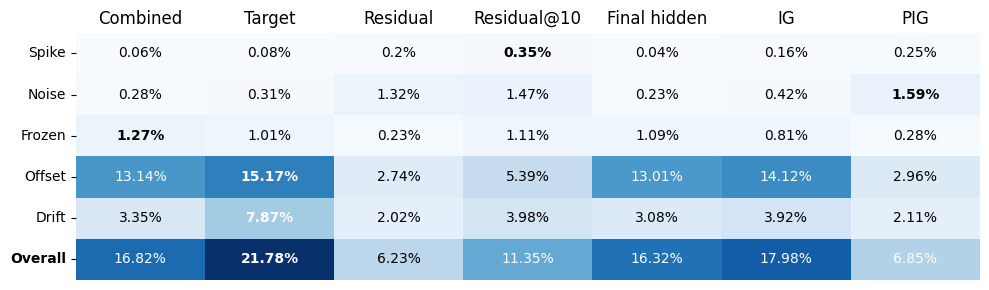

In [25]:
# Prepare the data
data_fmt = precision_df.to_numpy().round(2).astype(str)
# add a % sign to each value
data_fmt = np.char.add(data_fmt, '%')

# Create the heatmap
plt.figure(figsize=(10, 3))
ax = sns.heatmap(precision_df, annot=False, cmap='Blues', cbar=False)
annotate_heatmap(precision_df.to_numpy(), data_fmt, ax=ax, cmap='Blues')
# format
ax.yaxis.get_major_ticks()[0].label1.set_fontweight('bold')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(fontsize=12)
plt.gca().xaxis.set_tick_params(size=0)
plt.tight_layout()
plt.show()

#### Recall

In [26]:
# calculate precision score for each Data label
recall_scores = {}
for key in evaluate_keys:
    recall_scores[key] = {'Overall': recall_score(results['Actual'], results[key]['Predicted'])*100}
    for label in hue_order:
        if label == 'Original':
            continue
        mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')
        recall_scores[key][label] = recall_score(
            results['Actual'][mask], results[key]['Predicted'][mask]
        ) * 100

recall_df = pd.DataFrame(recall_scores)

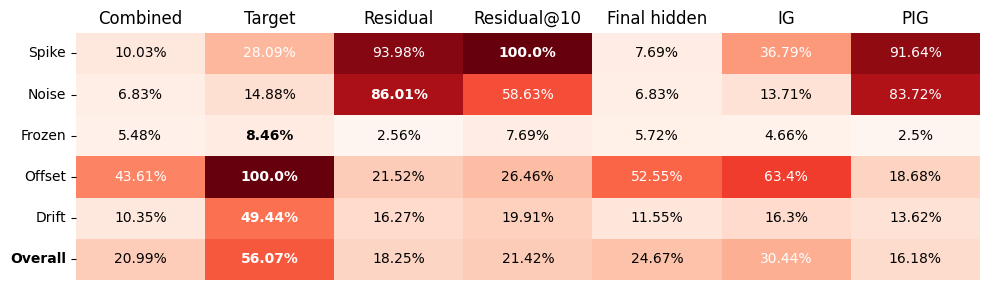

In [27]:
# Prepare the data
data_fmt = recall_df.to_numpy().round(2).astype(str)
# add a % sign to each value
data_fmt = np.char.add(data_fmt, '%')

# Create the heatmap
plt.figure(figsize=(10, 3))
ax = sns.heatmap(recall_df, annot=False, cmap='Reds', cbar=False)
annotate_heatmap(recall_df.to_numpy(), data_fmt, ax=ax, cmap='Reds')
# format
ax.yaxis.get_major_ticks()[0].label1.set_fontweight('bold')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(fontsize=12)
plt.gca().xaxis.set_tick_params(size=0)
plt.tight_layout()
plt.show()

In [28]:
def get_coverage(predicted, anomaly_start_end):
    # Given start and end of anomalies, find how much of the anomaly is covered by the prediction
    # Find all indices where the value is 1
    ones_indices = np.where(predicted == 1)[0]
    # Find the closest index in both directions
    if len(ones_indices) == 0:
        # do not continue
        raise ValueError("No anomalies detected")

    coverage = []

    for start, end in anomaly_start_end:
        # extract relevant data
        anomaly_data = predicted[start:end+1]
        
        # Coverage
        coverage.append(anomaly_data.sum() / len(anomaly_data))

    return coverage

def get_timing(predicted, anomaly_start_end):
    # Given start and end of anomalies, find how close the prediction is to the start
    # Find all indices where the value is 1
    ones_indices = np.where(predicted == 1)[0]
    # Find the closest index in both directions
    if len(ones_indices) == 0:
        # do not continue
        raise ValueError("No anomalies detected")

    timing = []

    for i, (start, end) in enumerate(anomaly_start_end):
        # Filter indices that are after the start
        valid_indices = ones_indices[ones_indices > start]

        if valid_indices.size > 0:  # Check if there are valid indices
            distances = np.abs(valid_indices - start)
            closest_index = valid_indices[np.argmin(distances)]
            timing.append(closest_index - start)
        else:
            # stop the loop
            print(f"Stopping with {len(anomaly_start_end) - i} anomalies left")
            break
    return timing

In [29]:
# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results['Actual']) if value == 1]
_, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)

#### Coverage

In [30]:
# calculate precision score for each Data label
coverage_scores = {}

for key in evaluate_keys:
    coverage_scores[key] = {'Overall': np.mean(get_coverage(results[key]['Predicted'], anomaly_start_end)) * 100}

    for label in hue_order:
        if label == 'Original':
            continue
        mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')
        _indices_of_ones = [index for index, value in enumerate(results['Actual'][mask]) if value == 1]
        _, _anomaly_start_end = find_unterrupted_sequences(_indices_of_ones, 0)
        coverage_scores[key][label] = np.mean(get_coverage(results[key]['Predicted'][mask], _anomaly_start_end)) * 100

coverage_df = pd.DataFrame(coverage_scores)

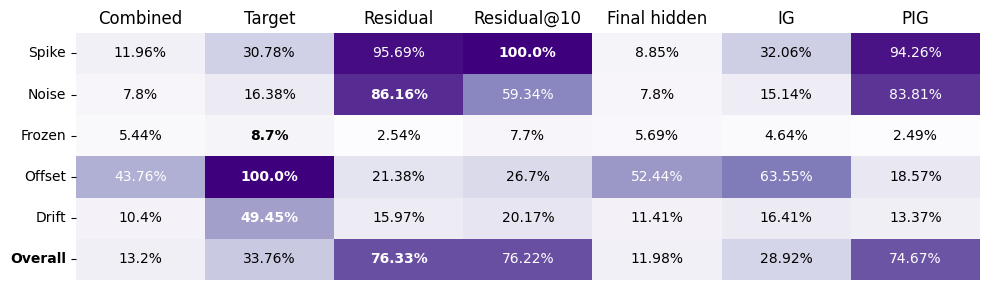

In [31]:
# Prepare the data
data_fmt = coverage_df.to_numpy().round(2).astype(str)
# add a % sign to each value
data_fmt = np.char.add(data_fmt, '%')

# Create the heatmap
plt.figure(figsize=(10, 3))
ax = sns.heatmap(coverage_df, annot=False, cmap='Purples', cbar=False)
annotate_heatmap(coverage_df.to_numpy(), data_fmt, ax=ax, cmap='Purples')
# format
ax.yaxis.get_major_ticks()[0].label1.set_fontweight('bold')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(fontsize=12)
plt.gca().xaxis.set_tick_params(size=0)
plt.tight_layout()
plt.show()

#### Timing

In [32]:
# calculate precision score for each Data label
timing_scores = {}

for key in evaluate_keys:
    timing_scores[key] = {'Overall': np.mean(get_timing(results[key]['Predicted'], anomaly_start_end))}
    for label in hue_order:
        if label == 'Original':
            continue
        mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')
        _indices_of_ones = [index for index, value in enumerate(results['Actual'][mask]) if value == 1]
        _, _anomaly_start_end = find_unterrupted_sequences(_indices_of_ones, 0)
        timing_scores[key][label] = np.mean(get_timing(results[key]['Predicted'][mask], _anomaly_start_end))

timing_df = pd.DataFrame(timing_scores)

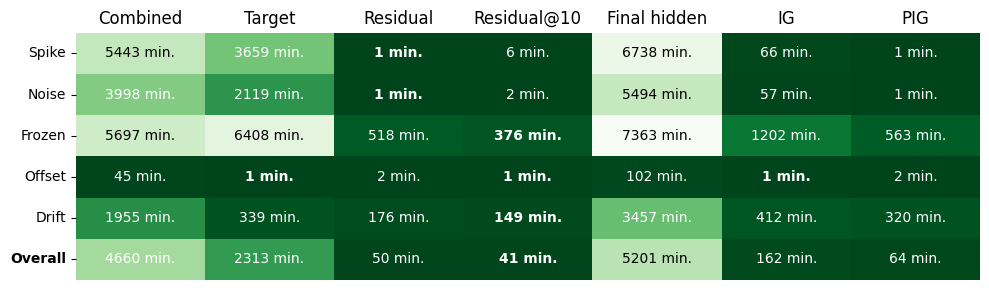

In [33]:
# Prepare the data
data_fmt = timing_df.to_numpy().round(0).astype(int).astype(str)
# add a % sign to each value
data_fmt = np.char.add(data_fmt, ' min.')

# Create the heatmap
plt.figure(figsize=(10, 3))
ax = sns.heatmap(timing_df, annot=False, cmap='Greens_r', cbar=False)
annotate_heatmap(timing_df.to_numpy(), data_fmt, ax=ax, cmap='Greens_r', high_best=False)
# format
ax.yaxis.get_major_ticks()[0].label1.set_fontweight('bold')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(fontsize=12)
plt.gca().xaxis.set_tick_params(size=0)
plt.tight_layout()
plt.show()

## Feature importance